In [1]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x5b988000 @  0x7f7d05bff2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import pandas as pd
import altair as alt
import copy

In [3]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])
aug_transform = T.Compose([
                T.RandomHorizontalFlip(),
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])                

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./data', train=True, download=True,
                             transform=aug_transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./data', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./data', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [5]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[  0.,   1.],
          [  2.,   3.],
          [  4.,   5.]]],


        [[[  6.,   7.],
          [  8.,   9.],
          [ 10.,  11.]]]])
After flattening:  tensor([[  0.,   1.,   2.,   3.,   4.,   5.],
        [  6.,   7.,   8.,   9.,  10.,  11.]])


In [0]:
import torch.nn.functional as F  # useful stateless functions


In [0]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [0]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

In [0]:

model = None
optimizer = None

def get_accuracy(loader, model):
      
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        return acc


def train_net(model, optimizer, epochs=1, print_loss=True, stop_at=None, scheduler=None):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: loss history
    """
    loss_history = []
    acc_history = []
    best_acc = 0.0
    best_model_wts = None
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        
        for t, (x, y) in enumerate(loader_train):
            if stop_at and t > stop_at:
                break
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            # save accuracy history
            loss_history.append(loss.item())
            accuracy = get_accuracy(loader_val, model)
            acc_history.append(accuracy)
            
            # check if best model
            if accuracy > best_acc:
                best_acc = accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if print_loss and t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()
               
        # adapt learning rate
        if scheduler and scheduler.__class__.__name__ == 'ReduceLROnPlateau':
            scheduler.step(accuracy)
        elif scheduler:
            scheduler.step()
        
        # print best accuracy for epoch
        print(f'Epoch: {e}, Best acc: {best_acc}')
              
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, loss_history, acc_history

def plot_loss_histories(results):
    # turn dataframe to long format
    data = pd.melt(results, id_vars='iter')
    
    return alt.Chart(data).mark_line().encode(
        alt.X('iter', type='quantitative', title='iteration'),
        alt.Y('value', type='quantitative', title='accuracy/loss'),
        color='variable'
    ).interactive()

    
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)
      
class Squeeze(nn.Module):
    def forward(self, x):
        return x.view(-1, 10)

def make_deep_model():
  deep_model = nn.Sequential(nn.Conv2d(3, 16, 3, stride=1, padding=1),
                        nn.BatchNorm2d(16),
                        nn.ReLU(),
                        nn.Conv2d(16, 16, 3, stride=1, padding=1),
                        nn.BatchNorm2d(16),
                        nn.ReLU(),
                        nn.Conv2d(16, 32, 2, stride=2, padding=0), # downsample
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        nn.Conv2d(32, 32, 3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        nn.Conv2d(32, 32, 3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        nn.Conv2d(32, 64, 2, stride=2, padding=0), # downsample
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        nn.Conv2d(64, 64, 3, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        nn.Conv2d(64, 64, 3, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        nn.Conv2d(64, 128, 2, stride=2, padding=0), # downsample
                        nn.BatchNorm2d(128),
                        nn.ReLU(),
                        nn.Conv2d(128, 128, 3, stride=1, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(),
                        nn.Conv2d(128, 128, 3, stride=1, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(),
                        nn.Conv2d(128, 10, 3, stride=1, padding=1), # prep for average pool
                        nn.BatchNorm2d(10),
                        nn.ReLU(),
                        nn.AvgPool2d(4, stride=1),
                        Squeeze()
                       )
  return deep_model

# custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        m.bias.data.fill_(0)      



## Choosing learning rate

In [24]:
learning_rates = [1e-1, 1e-2, 1e-3]

model = None
optimizer = None
results = {}

for lr in learning_rates:
    model = make_deep_model()
    model.apply(weights_init)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    model, _, accuracy_history = train_net(model, optimizer, epochs=1, print_loss=False, stop_at=200)
    results['lr_{:.6f}'.format(lr)] = accuracy_history
    # add iter column if not exist
    if not results.get('iter', None):
        results['iter'] = list(range(len(results['lr_{:.6f}'.format(lr)])))

results = pd.DataFrame(results)
plot_loss_histories(results)

Chart({
  data:      iter     variable  value
  0       0  lr_0.001000  0.099
  1       1  lr_0.001000  0.104
  2       2  lr_0.001000  0.104
  3       3  lr_0.001000  0.109
  4       4  lr_0.001000  0.106
  5       5  lr_0.001000  0.106
  6       6  lr_0.001000  0.109
  7       7  lr_0.001000  0.109
  8       8  lr_0.001000  0.112
  9       9  lr_0.001000  0.107
  10     10  lr_0.001000  0.109
  11     11  lr_0.001000  0.109
  12     12  lr_0.001000  0.110
  13     13  lr_0.001000  0.105
  14     14  lr_0.001000  0.097
  15     15  lr_0.001000  0.093
  16     16  lr_0.001000  0.086
  17     17  lr_0.001000  0.083
  18     18  lr_0.001000  0.082
  19     19  lr_0.001000  0.079
  20     20  lr_0.001000  0.078
  21     21  lr_0.001000  0.082
  22     22  lr_0.001000  0.086
  23     23  lr_0.001000  0.092
  24     24  lr_0.001000  0.093
  25     25  lr_0.001000  0.095
  26     26  lr_0.001000  0.095
  27     27  lr_0.001000  0.101
  28     28  lr_0.001000  0.103
  29     29  lr_0.001000  0.105
  ..    ...          ...    ...
  573   171  lr_0.100000  0.333
  574   172  lr_0.100000  0.413
  575   173  lr_0.100000  0.406
  576   174  lr_0.100000  0.374
  577   175  lr_0.100000  0.397
  578   176  lr_0.100000  0.408
  579   177  lr_0.100000  0.430
  580   178  lr_0.100000  0.452
  581   179  lr_0.100000  0.470
  582   180  lr_0.100000  0.474
  583   181  lr_0.100000  0.444
  584   182  lr_0.100000  0.424
  585   183  lr_0.100000  0.477
  586   184  lr_0.100000  0.487
  587   185  lr_0.100000  0.471
  588   186  lr_0.100000  0.488
  589   187  lr_0.100000  0.468
  590   188  lr_0.100000  0.468
  591   189  lr_0.100000  0.459
  592   190  lr_0.100000  0.462
  593   191  lr_0.100000  0.475
  594   192  lr_0.100000  0.462
  595   193  lr_0.100000  0.438
  596   194  lr_0.100000  0.383
  597   195  lr_0.100000  0.396
  598   196  lr_0.100000  0.422
  599   197  lr_0.100000  0.417
  600   198  lr_0.100000  0.427
  601   199  lr_0.100000  0.389
  602   200  lr_0.100000  0.408
  
  [603 rows x 3 columns],
  encoding: EncodingWithFacet({
    color: Color({
      shorthand: 'variable'
    }),
    x: X({
      shorthand: 'iter',
      title: 'iteration',
      type: 'quantitative'
    }),
    y: Y({
      shorthand: 'value',
      title: 'accuracy/loss',
      type: 'quantitative'
    })
  }),
  mark: 'line',
  selection: SelectionMapping({
    selector002: SelectionDef({
      bind: 'scales',
      encodings: ['x', 'y'],
      type: 'interval'
    })
  })
})

In [43]:
learning_rate = 1e-2
model = make_deep_model()
model.apply(weights_init)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', verbose=True, patience=1)
model, _, accuracy_history = train_net(model, optimizer, epochs=20, print_loss=False, scheduler=scheduler)

results = {}
results['accuracy'] = accuracy_history
results['iter'] = range(len(accuracy_history))

Epoch: 0, Best acc: 0.558
Epoch: 1, Best acc: 0.67
Epoch: 2, Best acc: 0.723
Epoch: 3, Best acc: 0.741
Epoch: 4, Best acc: 0.769
Epoch: 5, Best acc: 0.779
Epoch: 6, Best acc: 0.785
Epoch: 7, Best acc: 0.801
Epoch: 8, Best acc: 0.804
Epoch: 9, Best acc: 0.811
Epoch: 10, Best acc: 0.817
Epoch: 11, Best acc: 0.818
Epoch    12: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 12, Best acc: 0.826
Epoch: 13, Best acc: 0.834
Epoch: 14, Best acc: 0.84
Epoch    15: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 15, Best acc: 0.84
Epoch: 16, Best acc: 0.84
Epoch    17: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 17, Best acc: 0.84
Epoch: 18, Best acc: 0.84
Epoch    19: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 19, Best acc: 0.84


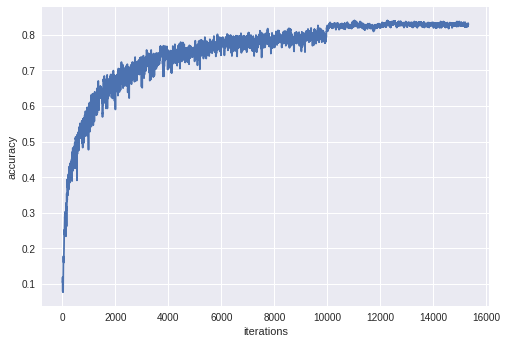

In [44]:
# import matplotlib.pyplot as plt
plt.plot(results['iter'], results['accuracy'])
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()

In [45]:
check_accuracy_part34(loader_test, model)

Checking accuracy on test set
Got 8115 / 10000 correct (81.15)
